# First we load and prepare the data as per the existing code

## Load dependencies and custom codes

In [1]:
import os, glob, re, spacy, nltk
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy.attrs

%matplotlib inline

from sklearn.utils import shuffle
from spacy import displacy
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
from scipy import stats
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Load the spacy model
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# A function to remove underscores from the text
def remove_underscores(text:str)->str:
    return text.replace("_", " ")

# A function to remove excess whitespaces from the text
def remove_excess_whitespace(text:str)->str:
    return " ".join(text.split())

# A function to remove \n or \t from the text
def remove_newline_tab(text:str)->str:
    return text.replace("\n", " ").replace("\t", " ")

# A function to remove quotations from the text
def remove_quotations(text:str)->str:
    return re.sub(re.compile("\[\d*\]"), "", text)

# A function to clean the text by calling the above functions
def clean_text(text:str)->str:
    text = remove_underscores(text)
    text = remove_newline_tab(text)
    text = remove_quotations(text)
    text = remove_excess_whitespace(text)
    text = text.lower()
    return text

# This function is for mapping the classes as per 0 or 1 for the machine learning state
def label_generation(text:str)->int:
    if text == "Women_Scientists":
      val = 0
    elif text == "US_Presidents":
      val = 1
    return val

# Break a text into a list of tokens 
def get_tokens(text):
    """A function that returns a list of tokens from a text, after removing stopwords and punctuations"""
    tokens = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop == False and token.is_punct == False:
            tokens.append(token.text)
    return tokens

## Load the data and clean the tokens

In [3]:
pre_sci_df = pd.read_csv("./data/all_data.csv")
pre_sci_df["clean_text"] = pre_sci_df["content"].apply(clean_text)
pre_sci_df["tokens"] = pre_sci_df["clean_text"].apply(get_tokens)
pre_sci_df["labels"] = pre_sci_df["category"].apply(label_generation)
pre_sci_df

,title,content,category,clean_text,tokens,labels
0,Eva Syková,Eva Syková (born 1944) is a Czech neuroscienti...,Women_Scientists,eva syková (born 1944) is a czech neuroscienti...,"[eva, syková, born, 1944, czech, neuroscientis...",0
1,Maria Kovacs,Maria Kovacs is an American psychologist and a...,Women_Scientists,maria kovacs is an american psychologist and a...,"[maria, kovacs, american, psychologist, academ...",0
2,Joanne Johnson,"\nJoanne S. Johnson (born 1977, Birmingham, né...",Women_Scientists,"joanne s. johnson (born 1977, birmingham, née ...","[joanne, s., johnson, born, 1977, birmingham, ...",0
3,Hua Eleanor Yu,Hua Eleanor Yu is the inaugural Billy and Audr...,Women_Scientists,hua eleanor yu is the inaugural billy and audr...,"[hua, eleanor, yu, inaugural, billy, audrey, l...",0
4,Manju Ray,Manju Ray was an Indian scientist specializing...,Women_Scientists,manju ray was an indian scientist specializing...,"[manju, ray, indian, scientist, specializing, ...",0
...,...,...,...,...,...,...
373,Jennifer Thomson,"\nJennifer Ann Thomson (born June 16, 1947) is...",Women_Scientists,"jennifer ann thomson (born june 16, 1947) is a...","[jennifer, ann, thomson, born, june, 16, 1947,...",0
374,William McKinley,"\nWilliam McKinley (January 29, 1843 – Septemb...",US_Presidents,"william mckinley (january 29, 1843 – september...","[william, mckinley, january, 29, 1843, septemb...",1
375,Priyamvada Natarajan,\nPriyamvada (Priya) Natarajan is a professor ...,Women_Scientists,priyamvada (priya) natarajan is a professor in...,"[priyamvada, priya, natarajan, professor, depa...",0
376,Afërdita Veveçka Priftaj,\nAfërdita Veveçka Priftaj (21 January 1948 – ...,Women_Scientists,afërdita veveçka priftaj (21 january 1948 – 4 ...,"[afërdita, veveçka, priftaj, 21, january, 1948...",0


## Perform feature extraction

In [4]:
def generate_bag_of_words(tokens, vocab):
  bag_of_words = np.zeros(len(vocab))
  for token in tokens:
    if token in vocab:
      index = vocab.index(token)
      bag_of_words[index] += 1
  return bag_of_words

def generate_vocab(tokens):
  vocab = []
  for token in tokens:
    if token not in vocab:
      vocab.append(token)
  return vocab


from sklearn.model_selection import train_test_split


"""
Feature extraction in strings can happen in various ways. Here we are using the concept of bag of words

Here is a list of possible techniques:

1. One Hot Encoding
2. Bag of Word (BOW) <- Used here
3. n-grams
4. Tf-Idf
5. Custom features
6. Word2Vec(Word Embedding)


A quick refresher can be read from : https://www.analyticsvidhya.com/blog/2022/05/a-complete-guide-on-feature-extraction-techniques/
"""

# Assume that we have a list of text samples as strings
#text_samples = ['This is the first sample', 'This is the second sample', 'Another sample']
# Tokenize each text sample into a list of words
#tokenized_samples = [sample.lower().split() for sample in text_samples]

tokenized_samples = pre_sci_df["tokens"]

# Generate the vocabulary from the list of words
vocab = generate_vocab([token for tokens in tokenized_samples for token in tokens])

# Generate the bag-of-words vectors for each text sample
X_list = []

for tokens in tokenized_samples:
  bag_of_words = generate_bag_of_words(tokens, vocab)
  X_list.append(bag_of_words)

X = np.array(X_list)

# Printing here for a quick overview disable if not needed
print("--Printing Vocab---\n")
print(vocab)


print("--Printing word vectors--\n")
print(X)


--Printing Vocab---

['eva', 'syková', 'born', '1944', 'czech', 'neuroscientist', 'research', 'focused', 'origins', 'mechanisms', 'maintenance', 'ionic', 'volume', 'homeostasis', 'cns', 'role', 'extrasynaptic', 'transmission', 'spinal', 'cord', 'injury', 'currently', 'leading', 'clinical', 'studies', 'including', 'phase', 'ii', 'study', 'patients', 'ongoing', 'als', 'ischemic', 'leg', 'director', 'institute', 'experimental', 'medicine', 'head', 'center', 'cell', 'therapy', 'tissue', 'repair', 'charles', 'university', 'prague', 'author', '421', 'publications', 'co', 'holder', '7', 'patents', 'h', 'index', '50', 'article', 'scientist', 'stub', 'help', 'wikipedia', 'expanding', 'it.this', 'neuroscience', 'maria', 'kovacs', 'american', 'psychologist', 'academic', 'distinguished', 'professor', 'psychiatry', 'pittsburgh', 'school', 'developer', 'children', 'depression', 'inventory', 'earned', 'undergraduate', 'degree', 'psychology', 'queens', 'college', 'city', 'new', 'york', 'master', 'teac

## Run the model training

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import hard_sigmoid

# Generate the labels for each text sample
y = pre_sci_df["labels"].to_numpy()

# Split into test and train data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)
   
# Create the 'Perceptron' using the Keras API
model = Sequential()
model.add(Dense(1, input_shape=(len(vocab),), activation=hard_sigmoid, kernel_initializer='glorot_uniform'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train the perceptron using stochastic gradient descent
# with a validation split of 20%
model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=1, validation_split=0.2)

# Evaluate the model accuracy
_,accuracy = model.evaluate(X_test, y_test)

# Print the Statistics
#print(f"Loss: {loss}\n")
print(f"Accuracy: {accuracy}\n")
#print(f"F1_score: {f1_scr}\n")
#print(f"Precision: {precision}\n")
#print(f"Recall: {recall}\n")


Epoch 1/50
49/49 [==============================] - 2s 24ms/step - loss: 0.3397 - accuracy: 0.9710 - val_loss: 0.1305 - val_accuracy: 1.0000
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.0586 - accuracy: 1.0000 - val_loss: 0.0803 - val_accuracy: 1.0000
Epoch 3/50
49/49 [==============================] - 0s 5ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.0616 - val_accuracy: 1.0000
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 1.0000
Epoch 5/50
49/49 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0464 - val_accuracy: 1.0000
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0438 - val_accuracy: 1.0000
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 1.0000
Epoch 8/50
49/49 [=

## Print the confusion matrix

3/3 [==============================] - 0s 5ms/step


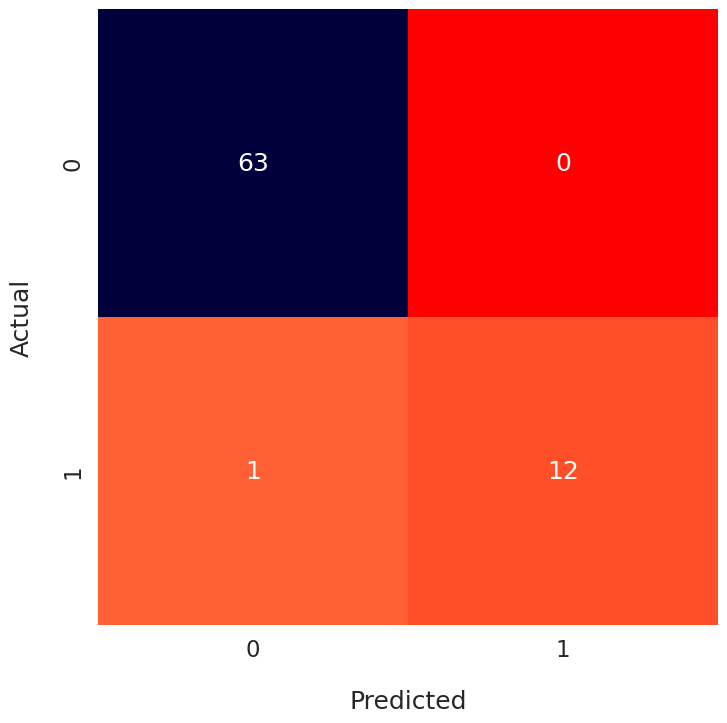

In [14]:
# Lets print some more statistics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Get the predictions for the test dataset
#y_test_predictions = model.predict(X_test)
y_predictions_classes=(model.predict(X_test) > 0.5).astype("int32")
#print(y_test_predictions)
#print(y_predictions_classes)
# Generate confusion matrix for the predictions
conf_matrix = confusion_matrix(y_test, y_predictions_classes)


plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()


## Get accuracy, precision, recall and F1 scores

In [15]:
accuracy = accuracy_score(y_test, y_predictions_classes)
precision = precision_score(y_test, y_predictions_classes)
recall = recall_score(y_test, y_predictions_classes)
f1score = f1_score(y_test, y_predictions_classes)
print(f"Accuracy = {accuracy}\n")
print(f"Precision = {precision}\n")
print(f"Recall = {recall}\n")
print(f"F1 Score = {f1score}\n")

Accuracy = 0.9868421052631579

Precision = 1.0

Recall = 0.9230769230769231

F1 Score = 0.9600000000000001



# This is a proof of concept

In [ ]:
import nltk
import sklearn
from sklearn.metrics import f1_score


print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:


# Generate the labels for each text sample
y = pre_sci_df["labels"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    # Train the perceptron on the bag-of-words vectors and labels
perceptron = Perceptron(input_size=len(vocab), learning_rate=0.1, epochs=100)
perceptron.train(X_train, y_train)

    # Evaluate the trained perceptron on the training set
accuracy, precision, recall, f1 = perceptron.evaluate(X_test,y_test)
print(f"Accuracy is {accuracy}\n")
print(f"Precision is {precision}\n")
print(f"Recall is {recall}\n")
print(f"f1 is {f1}\n")


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class Perceptron:
    def __init__(self, input_size, learning_rate=0.1, epochs=100):
        self.weights = np.zeros(input_size + 1)
        self.learning_rate = learning_rate
        self.epochs = epochs

    def activation_fn(self, x):
        return 1 if x >= 0 else 0
        #return 1 / (1 + np.exp(-x))

    def predict(self, x):
        z = self.weights.T.dot(x)
        a = self.activation_fn(z)
        return a

    def train(self, X, y):
        X = np.insert(X, 0, 1, axis=1)

        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                x = X[i]
                y_pred = self.predict(x)
                error = y[i] - y_pred
                self.weights = self.weights + self.learning_rate * error * y_pred * (1 - y_pred) * x

    def evaluate(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        y_pred = []
        for i in range(X.shape[0]):
            x = X[i]
            y_pred_i = self.predict(x)
            if y_pred_i >= 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)

        accuracy = np.mean(np.array(y_pred) == y)
        precision = precision_score(y, y_pred, average='binary')
        recall = recall_score(y, y_pred, average='binary')
        f1 = f1_score(y, y_pred, average='binary')

        return accuracy, precision, recall, f1

    @staticmethod
    def generate_bag_of_words(tokens, vocab):
        bag_of_words = np.zeros(len(vocab))
        for token in tokens:
            if token in vocab:
                index = vocab.index(token)
                bag_of_words[index] += 1
        return bag_of_words

    @staticmethod
    def generate_vocab(tokens):
        vocab = []
        for token in tokens:
            if token not in vocab:
                vocab.append(token)
        return vocab




In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import hard_sigmoid


if __name__ == "__main__":
    # Load the Pima diabetes dataset from CSV
    # and convert into a NumPy matrix suitable for
    # extraction into X, y format needed for TensorFlow
    diabetes = pd.read_csv('diabetes.csv').values

    # Extract the feature columns and outcome response
    # into appropriate variables
    X = np.asarray(diabetes[:, 0:8]).astype(np.float32)
    y = diabetes[:, 8]

    # Create the 'Perceptron' using the Keras API
    model = Sequential()
    model.add(Dense(1, input_shape=(8,), activation=hard_sigmoid, kernel_initializer='glorot_uniform'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the perceptron using stochastic gradient descent
    # with a validation split of 20%
    model.fit(X, y, epochs=225, batch_size=25, verbose=1, validation_split=0.2)

    # Evaluate the model accuracy
    _, accuracy = model.evaluate(X, y)
    print("%0.3f" % accuracy)